# 캐글 주택 가격 : 고급 회귀 기법

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

79개의 변수로 구성된 이 데이터는 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보를 가지고 있다. 성능평가는 RMSLE(Root Mean Squared Log Error)를 기반으로 한다. 가격이 비싼 주택일수록 예측 결과 오류가 전체 오류에 미치는 비중이 높으므로 이것을 상쇄하기 위해 오류 값을 로그 변환한 RMSLE를 이용한다.

### 데이터 사전 처리(Preprocessing)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('./house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


Target값은 맨 마지막 칼럼인 SalePrice이다.

In [2]:
print('데이터 세트의 Shape :',house_df.shape)
print('\n전체 피처의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n',isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape : (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


데이터 세트는 1460개의 레코드와 81개의 피처로 구성돼 있으며, 피처 타입은 숫자형과 문자형으로 되어있다. Target를 제외한 80개의 피처 중 43개가 문자형이며 나머지가 숫자형이다. 데이터 양에 비해 Null 값이 많은 피처도 있다.

PoolQC, MiscFeature, Alley, Fence는 1000개가 넘는 데이터가 Null이다.Null값이 너무 많은 피처는 드롭한다.

우선 회귀 모델을 적용하기 전에 전체 타깃 값의 분포가 정규 분포인지 확인

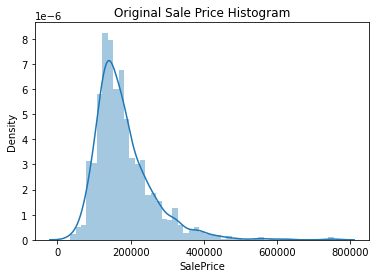

In [3]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어나있다. 정규 분포가 아닌 결과값을 정규 분포 형태로 변환하기 위해 로그 변환(Log Transformation)을 적용한다.

넘파이의 log1p()를 이용해 로그 변환한 결과값을 기반으로 학습한 뒤, 예측 시에는 다시 결과값을 expm1()으로 스케일 반환한다.

변환 후 다시 분포도를 확인

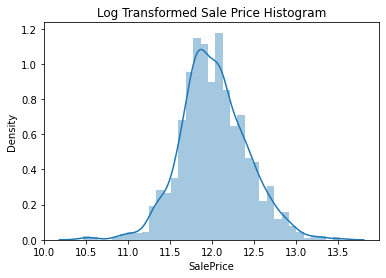

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

로그 변환으로 정규 분포 형태로 결과값이 분포하게 되었다. 이제 SalePrice를 로그 변환하여 DataFrame에 반영한다.

그리고 Null값이 많은 피처인 PoolQC, MiscFeature, Alley, Fence, FireplaceQu는 삭제.

Id는 단순 식별자이므로 삭제.

LotFrontage는 Null이 259개로 비교적 많으나 평균값으로 대체.

나머지 Null에 대해서는 Null이 많지 않으므로 숫자형의 경우 평균값으로 대체.

In [5]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type:\n',house_df.dtypes[null_column_count.index])

## Null 피처의 Type:
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자형 피처를 제외하고는 Null값이 없다. 이제 문자형 피처는 원-핫 인코딩으로 변환한다. 판다스의 get_dummies()를 이용한다.

get_dummies()는 null값에 대해서는 'None'칼럼으로 대체해주기 때문에 별도의 Null 값을 대체하는 로직이 필요없다.

In [6]:
print('get_dummies() 수행 전 데이터 shape:',house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:',house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type:\n',house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 271)
## Null 피처의 Type:
 Series([], dtype: object)


원-핫 인코딩 후 피처가 75개에서 271개로 증가했다. Null값을 가진 피처는 존재하지 않는다.

### 선형 회귀 모델 학습/예측/평가

In [7]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' 로그 변환된 RMSE :',np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [8]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression Ridge Lasso 학습 예측 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE : 0.132
Ridge  로그 변환된 RMSE : 0.128
Lasso  로그 변환된 RMSE : 0.176


[0.13189576579154205, 0.12750846334052995, 0.17628250556471403]

라쏘의 경우 회귀 성능이 타 회귀 방식보다 많이 떨어지는 결과가 나왔다. 라쏘의 경우 최적 하이퍼 파라미터 튜닝이 필요해 보인다.

먼저 피처별 회귀 계수를 시각화하여 모델별로 어떠한 피처의 회귀 계수로 구성되어있는지 확인해본다. 상위/하위 10개씩 확인.

In [9]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개, - 하위 10개의 회귀 꼐수를 추출해 반환
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

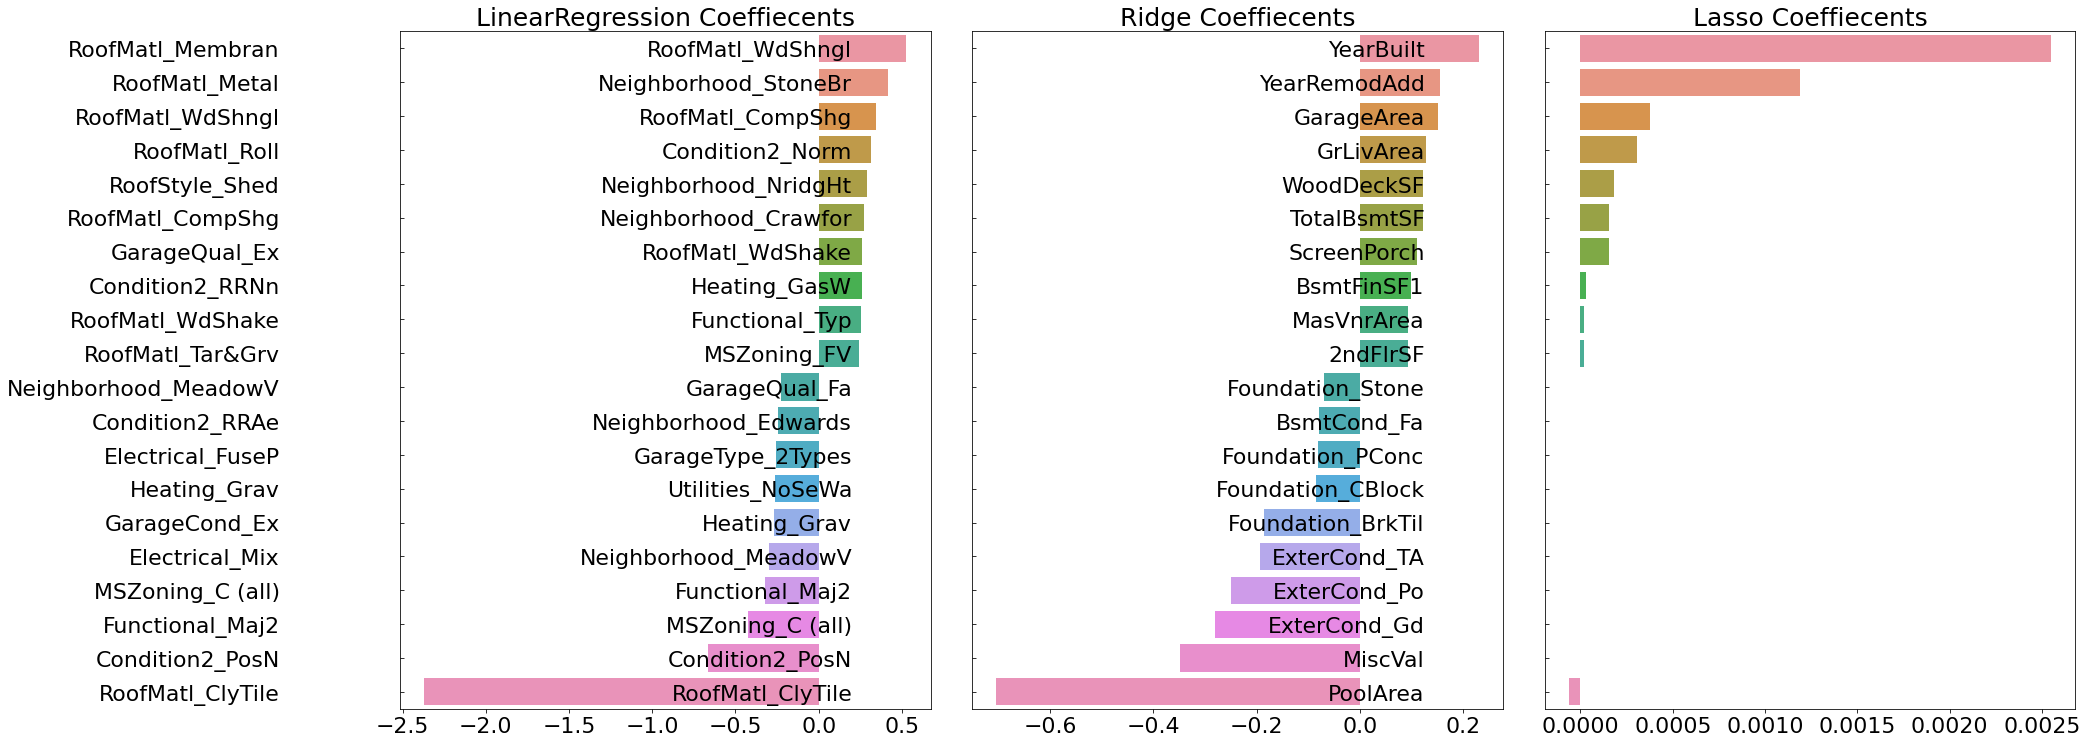

In [10]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction='in', pad=120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

라쏘의 경우 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처들의 회귀 계수는 너무 작다.

문제를 확인하기 위해, 학습 데이터의 데이터 분할을 하지 않고 X_features와 y_target을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE를 측정

In [11]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별로 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트 : {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값 : {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트 : [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값 : 0.155

Ridge CV RMSE 값 리스트 : [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값 : 0.144

Lasso CV RMSE 값 리스트 : [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값 : 0.198


5개의 폴드 세트로 학습한 후 평가해도 라쏘 성능이 떨어진다.

릿지와 라쏘 모델에 대해서 alpha 하이퍼 파라미터를 변화시키면서 최적값을 도출해본다.

In [12]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha : {2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha : {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha : {'alpha': 0.001}


alpha 값 최적화 이후 라쏘의 예측 성능이 많이 좋아졌다. alpha값을 적용하여 train_test_split()으로 분할된 학습 데이터와 테스트 데이터를 이용해 학습/예측/평가 수행한 후, 모델별 회귀 계수 시각화.

LinearRegression  로그 변환된 RMSE : 0.132
Ridge  로그 변환된 RMSE : 0.124
Lasso  로그 변환된 RMSE : 0.12


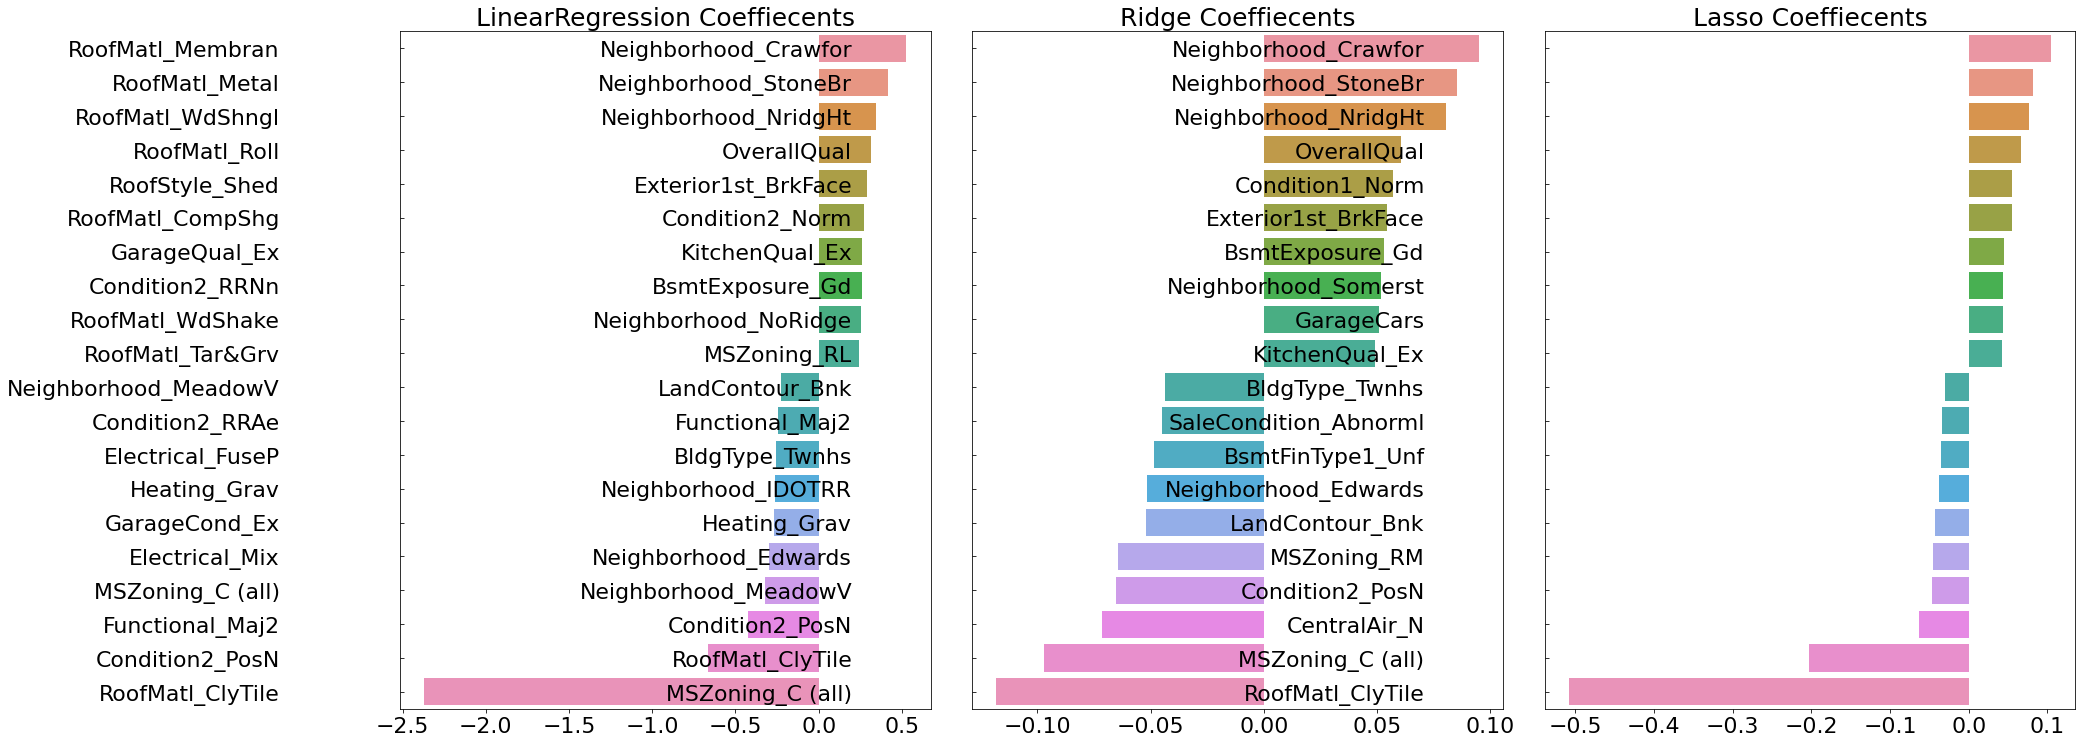

In [13]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌으며, 라쏘의 회귀 계수가 두 개의 모델과 비슷해졌다. 하지만 라쏘의 경우 릿지에 비해 동일한 피처라도 회귀 계수 값이 상당히 작다. 그래서 데이터 세트를 추가적으로 가공해 모델 튜닝을 진행해본다.

피처 데이터 세트의 경우 지나치게 왜곡된 피처가 존재할 경우 회귀 예측 성능을 저하시킬 수 있다. 모든 숫자형 피처의 데이터 분포도를 확인해 분포도가 어느 정도로 왜곡됐는지 알아본다.

사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있다. DataFrame에서 숫자형 피처의 왜곡 정도를 확인해본다.일반적으로 skew() 함수의 반환 값이 1 이상인 경우를 왜곡 정도가 높다고 판단하지만 상황에 따라 편차는 있다.

1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환한다.

** 주의 : skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외해야 한다. **

In [14]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew()를 호출
skew_features = house_df[features_index].apply(lambda x:skew(x))

# skew(왜곡) 정도가 1이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [15]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

로그 변환 후에도 왜곡 정도를 확인해보면 높은 왜곡 정도를 가진 피처가 있지만, 로그 변환으로 더이상 개선하기 어려우므로 그대로 유지.

house_df의 피처를 일부 로그 변환했으므로 다시 원-핫인코딩을 한다.

In [16]:
# Skew가 높은 피처들을 로그 변환했으므로 다시 원-핫 인코딩 적용 및 피처/타켓 데이터 셋 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha : {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha : {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE : 0.128
Ridge  로그 변환된 RMSE : 0.122
Lasso  로그 변환된 RMSE : 0.119


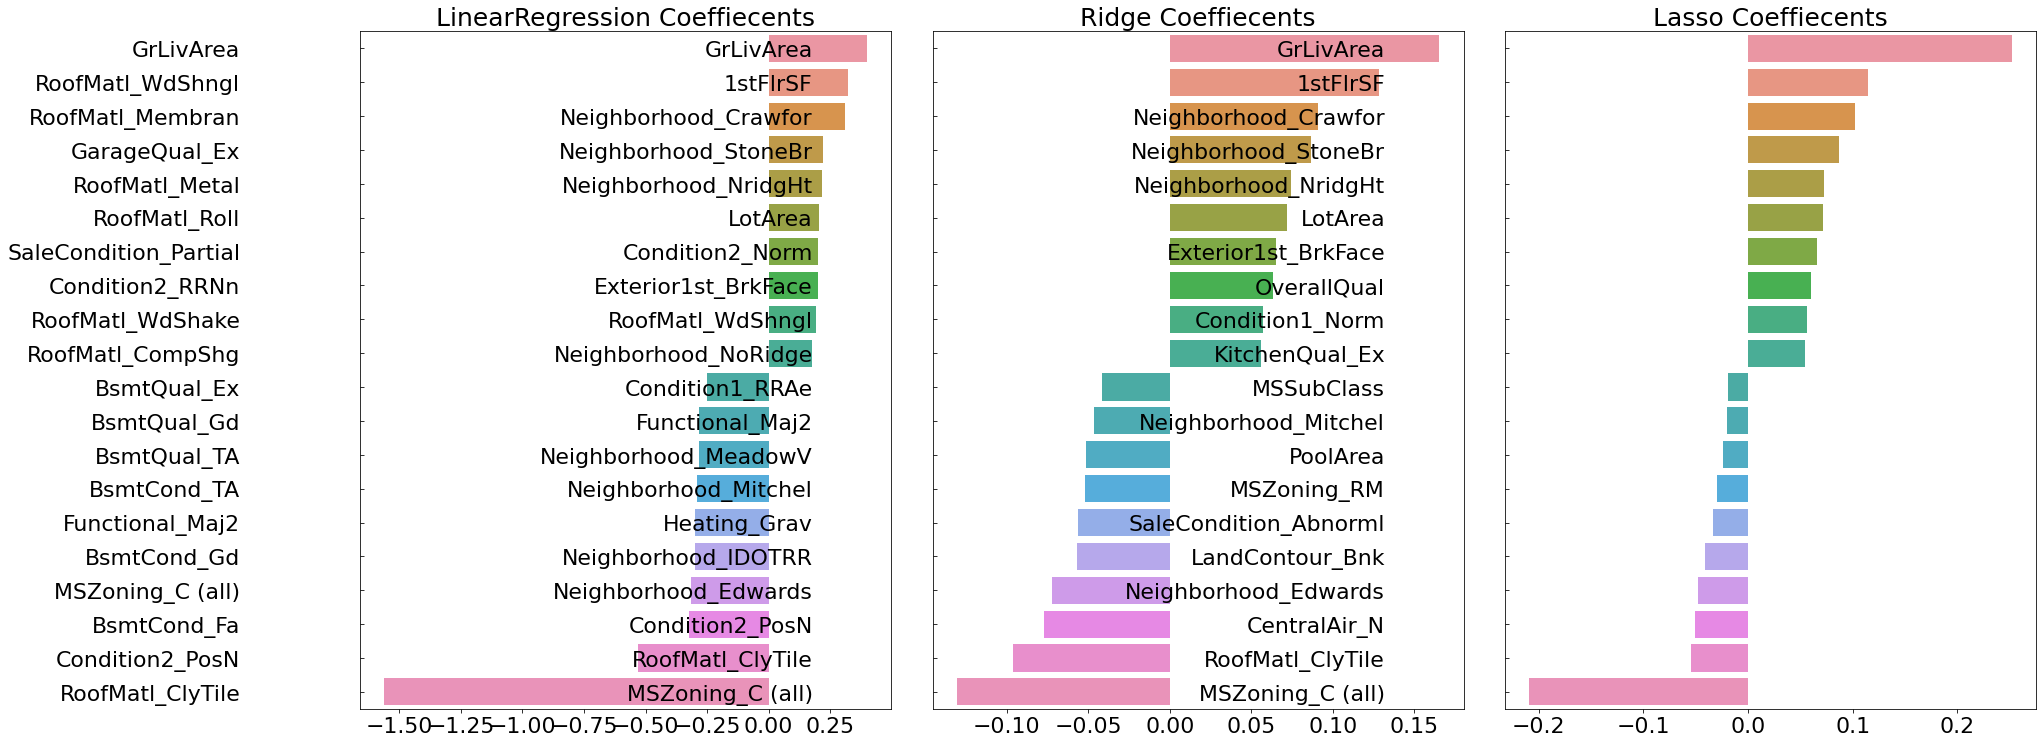

In [17]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

세 모델 모두 GrLivArea, 주거 공간 크기의 회귀 계수가 가장 높은 치처가 되었다. 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 도출된 것이다.

이번에는 이상치 데이터에 대해 분석해본다. 특히 회귀 계수가 높은 피처, 즉 예측에 많은 영향을 미치는 중요 피처의 이상치 데이터 처리가 중요하다.

먼저 세 모델 모두에서 가장 큰 회귀 계수를 가지는 GrLivArea 피처의 데이터 분포를 확인해보자.

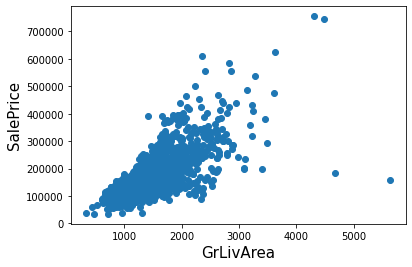

In [18]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

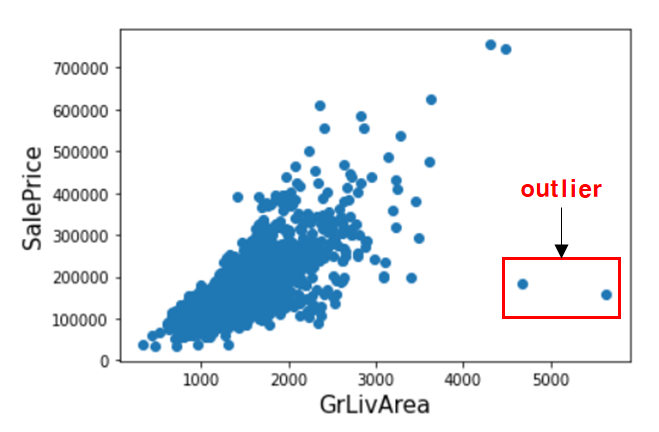

일반적으로 주거공간이 큰 집일수록 가격이 비싸기 때문에 GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있다. 하지만 위 그림에서의 네모의 2개 데이터는 일반적인 GrLivArea와 SalePrice 관계에서 너무 어긋나있다. 두 데이터의 GrLivArea가 가장 큼에도 불구하고 가격은 매우 낮다. 그래서 이 두 데이터를 삭제하도록 한다.

데이터 변환이 모두 변환된 house_df_ohe에서 대상 데이터를 필터링한다.

In [19]:
# GrLivArea와 SalePrice 모두 로그 변환했으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :',outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape :',house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape :', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape : (1460, 271)
이상치 삭제 후 house_df_ohe shape : (1458, 271)


In [20]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha : {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha : {'alpha': 0.001}


이상치 제거 후 예측 수치가 매우 크게 향상되었다. 이상치가 제거된 데이터 세트를 기반으로 다시 train_test_split()로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수를 시각화한다.

LinearRegression  로그 변환된 RMSE : 0.129
Ridge  로그 변환된 RMSE : 0.103
Lasso  로그 변환된 RMSE : 0.1


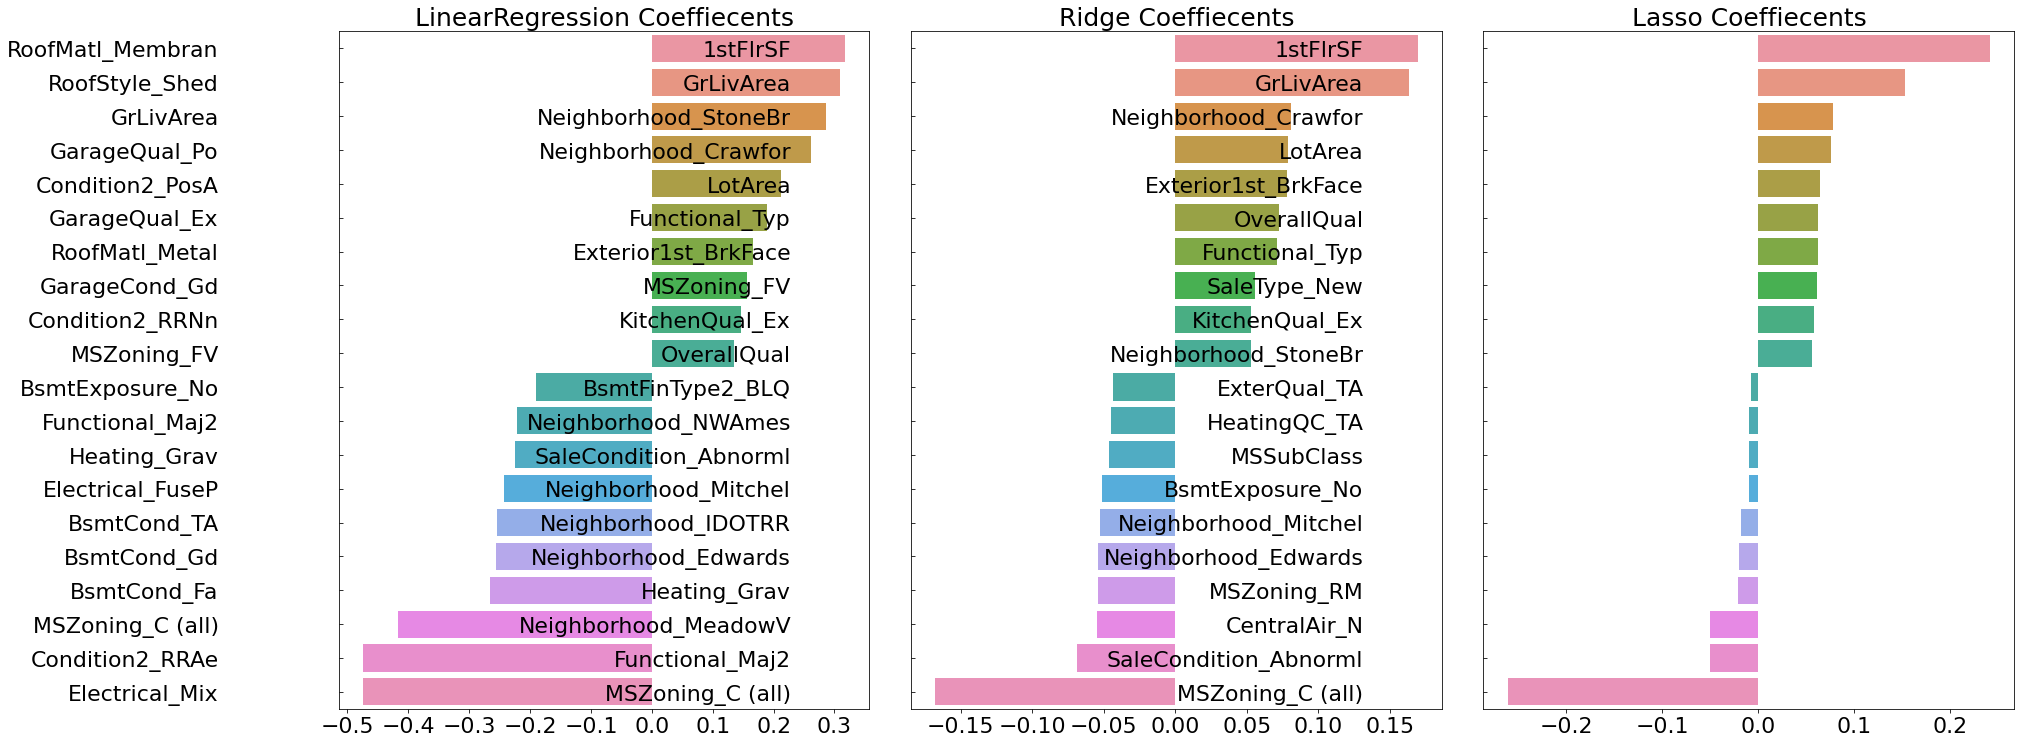

In [21]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

# 회귀 트리 모델 학습/예측/평가 - XGBoost, LightGBM

In [22]:
# XGBoost
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, objective='reg:squarederror')
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.115, 최적 alpha : {'n_estimators': 1000}


In [23]:
# LightGBM
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1161, 최적 alpha : {'n_estimators': 1000}


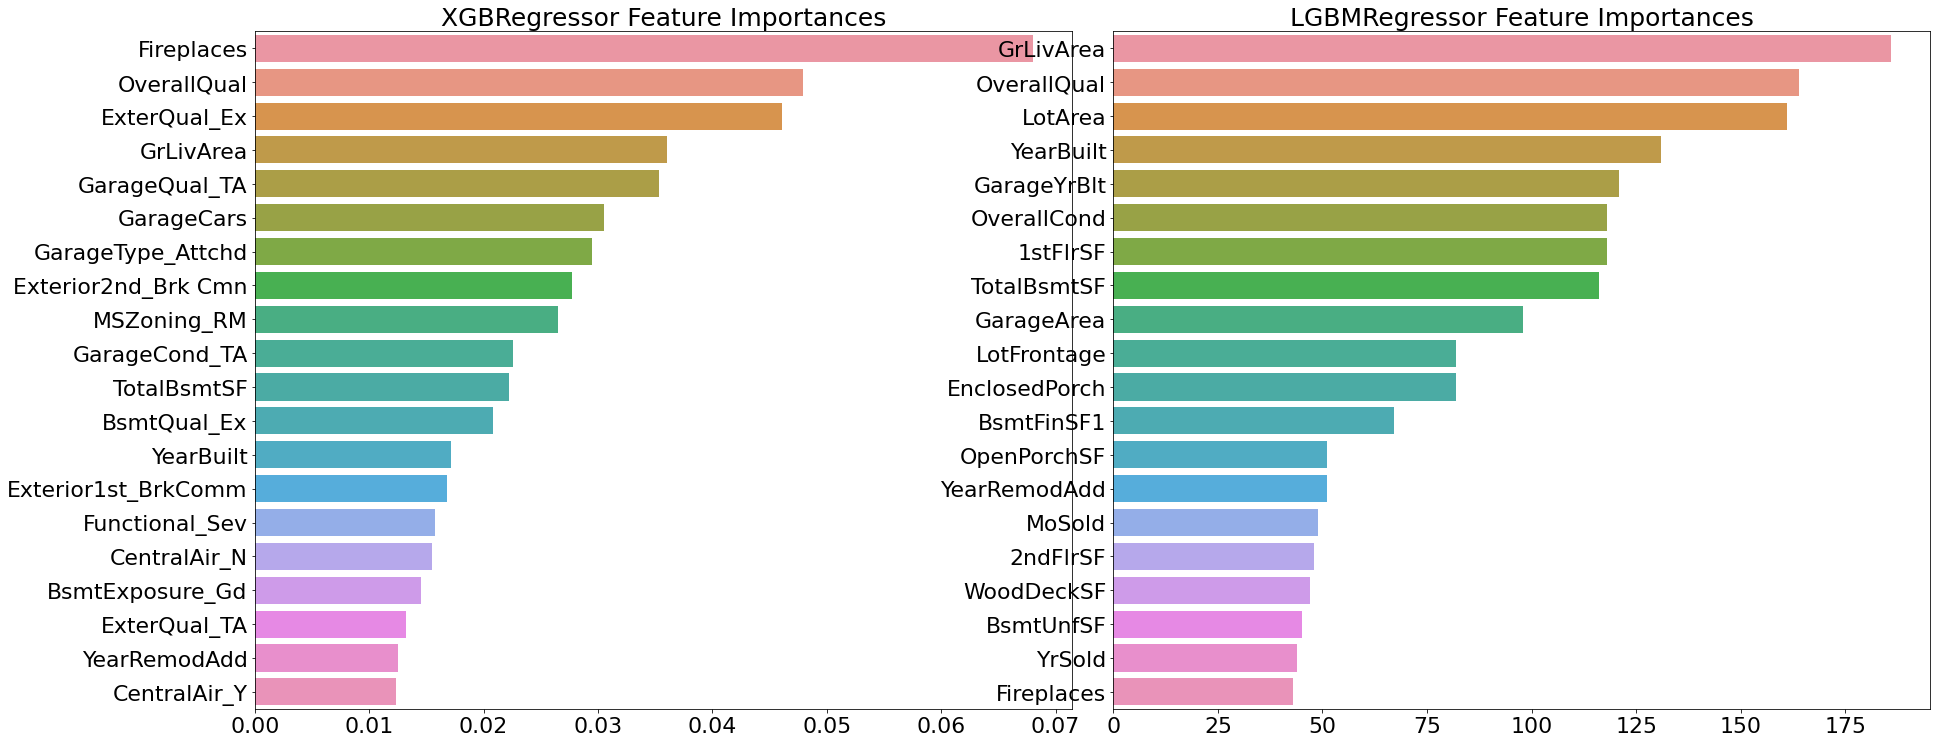

In [24]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

# 회귀 모델의 예측 결과 혼합을 통한 최종 예측

개별 회귀 모델의 예측 결과값을 혼합해 이를 기반으로 최종 회귀 값을 예측한다.

### 예측결과 혼합
1. A모델의 예측값의 40%, B모델의 예측값의 60%
2. A모델의 예측값 = [100, 80, 60], B모델의 예측값 = [120, 80, 50]
3. 최종 예측값 = [100*0.4 + 120*0.6, 80*0.4 + 80*0.6, 60*0.4 + 50*0.6]


In [25]:
# 릿지와 라쏘 혼합
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE : {1}'.format(key, rmse))

# 개별 모델 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합':pred,
         'Ridge':ridge_pred,
         'Lasso':lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10007930884470513
Ridge 모델의 RMSE : 0.10345177546603244
Lasso 모델의 RMSE : 0.10024170460890035


최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 조금 더 개선되었다. 릿지 모델 예측값에 0.4, 라쏘 모델 예측값에 0.6을 곱한 뒤 더한다. 

0.4나 0.6을 정하는 기준은 특별히 없으나, 두 개 중 성능이 조금 더 좋은 쪽에 가중치를 높인다.

In [26]:
# XGBoost와 LightGBM 혼합
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8, objective='reg:squarederror')
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합':pred,
         'XGBM':xgb_pred,
         'LGBM':lgbm_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.09897715854093486
XGBM 모델의 RMSE : 0.10075115846547565
LGBM 모델의 RMSE : 0.1015065721553885


# 스태킹 앙상블 모델을 통한 회귀 예측

### 스태킹 모델
* 두 종류의 모델 필요 = 개별적인 기반 모델과 이 개벼 ㄹ기반 모델의 예측 데이터르 학습 데이터로 만들어서 학습하는 최종 메타 모델
* 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합 -> 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

### 최종 메타 모델
* 최종 메타 모델이 학습할 피처 데이터 세트는 원본 학습 피처 세트로 학습한 개별 모델의 예측값을 스태킹 형태로 결합한 것


In [27]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

get_stacking_base_datasets()는 인자로 개별 기반 모델, 그리고 원래 사용되는 학습 데이터와 테스트용 피처 데이터를 입력받는다.

함수 내에서는 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본의 학습 데이터를 다시 추출해 학습과 예측을 수행한 후 그 결과를 저장.

저장된 예측 데이터는 이후 메타 모델의 학습 피처 데이터 세트로 이용

또한 함수 내에서 폴드 세트 내부 학습 데이터로 학습된 개별 모델이 인자로 입력된 원본 테스트 데이터를 예측한 뒤, 예측 결과를 평균해 테스트 데이터로 생성.

In [28]:
# 릿지, 라쏘, XGBoost, LightGBM으로 스태킹
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 배열 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


각 개별 모델이 반환한 학습용/테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용.

In [29]:
# 개별 모델이 반환한 학습/테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델 적용
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE :',rmse)

스태킹 회귀 모델의 최종 RMSE : 0.09738961783055029


최종 혼합 모델의 RMSE : 0.09897715854093486

스태킹 회귀 모델의 최종 RMSE : 0.09738961783055029

현재까지 가장 좋은 성능 평가를 보여준다. 스태킹 모델은 분류뿐만 아니라 회귀에서도 특히 효과적으로 사용할 수 있는 모델이다.

# 정리
<br/>
* 선형 회귀는 실제값과 예측값의 차이인 오류를 최소로 줄일 수 있는 선형 함수를 찾아서 이 선형 함수에 독립변수(피처)를 입력해 종속변수(타깃값, 예측값)을 예측하는 것이다.

* 이 최적의 선형 함수를 찾기 위해 실제값과 예측값 차이의 제곱을 회귀 계수 W를 변수로 하는 비용 함수를 만들고, 이 비용 함수가 최소화되는 W의 값을 찾아 선형 함수를 도출할 수 있다.

* 비용함수를 최소화할 수 있는 방법으로 경사 하강법이 있다.
<br/>
---
<br/>
* 실제값과 예측값의 차이를 최소화하는 것에만 초점을 맞추면 학습 데이터에 과적합되기 쉽다.

* 과적합 문제를 해결하기 위해 규제를 선형 회귀에 적용한다

* 대표적인 규제 선형 회귀는 L2 규제를 적용한 릿지, L1 규제를 적요한 라쏘, 그리고 L1에 L2를 결합한 엘라스틱넷으로 나누어진다.
<br/>
---
<br/>
* 선형 회귀를 분류에 적용한 대표적인 모델 = 로지스틱 회귀

* 로지스틱 회귀는 선형 함수 대신 최적의 시그모이드 함수를 도출하고, 독립변수(피처)를 이 시그모이드 함수에 입력해 반환된 결과를 확률값으로 변환해 예측 레이블을 결정한다.

* 로지스틱 회귀는 매우 뛰어난 분류 알고리즘이며, 특히 이진 분류나 희소 행렬로 표현되는 텍스트 기반의 분류에서 높은 성능 예측을 나타낸다.
<br/>
---
<br/>
* 회귀 트리 = 선형(또는 비선형) 회귀와 같이 최적의 선형(또는 비선형) 함수를 찾아낸다.

* 회귀트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산한다. 결정 트리, 랜덤 포레스트, GBM, XGBoost, LightGBM 모두 회귀 트리를 이용해 회귀를 수행하는 방법을 제공.
<br/>
---
<br/>
* 선형 모델을 기반으로 하는 선형 회귀는 데이터 값의 분포도와 인코딩 방법에 많은 영향을 받을 수 있다.

* 선형 회귀는 데이터 값의 분포도가 정규 분포와 같이 종 모양 형태를 선호. 특히 타깃값의 분포도가 왜곡되지 않고 정규 분포 형태로 되어야 예측 성능을 저하시키지 않는다.

* 데이터 세트의 왜곡 -> 로그 변환. 선형 회귀의 경우 데이트 세트에 카테고리형 데이터가 있을 경우 -> 원-핫 인코딩